In [3]:
!nvidia-smi

Tue Mar 26 05:05:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |     80MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import gc
from os.path import join as pjoin
import os
from datetime import datetime
import time

In [13]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy,ShowGraph,Clas
import torch

## Prepare for loging

In [6]:
import json
import os.path
import re
import ipykernel
import requests


from requests.compat import urljoin

from notebook.notebookapp import list_running_servers

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path


from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')



In [7]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
MODEL_NAME = get_notebook_name().split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
save_folder = f"{version:0>3d}" +'.'+date
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,save_folder)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/resnet18-fastai/004.26-03-2019-05-05'

In [8]:
print(f"""
Note for version {version} model {MODEL_NAME}:
Train the model with 2 rounds
For next version => use imagesnets stats to normalize
""")


Note for version 4 model resnet18-fastai:




# Init data loader

In [9]:
data_path = './data/'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,size=48,ds_tfms=tfms,bs=16,test='test')
       .normalize())

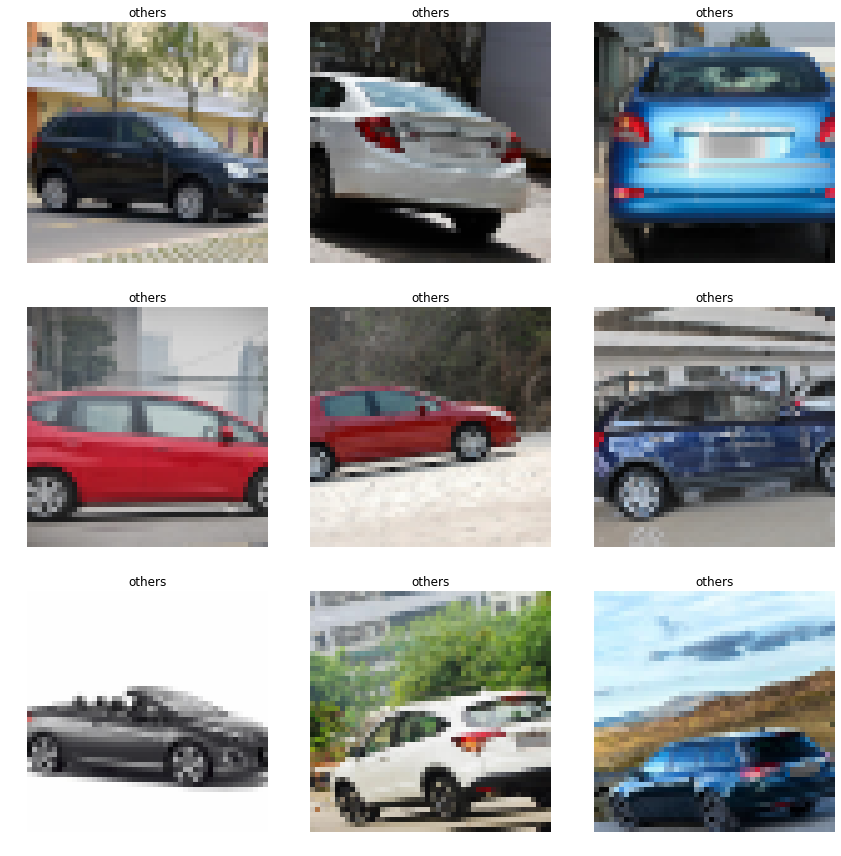

In [10]:
data.show_batch(rows=3)

In [11]:
model = models.resnet18

In [14]:
learn = cnn_learner(data, model,callback_fns=ShowGraph)

In [15]:
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.model_dir = os.path.abspath(model_save_dir)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


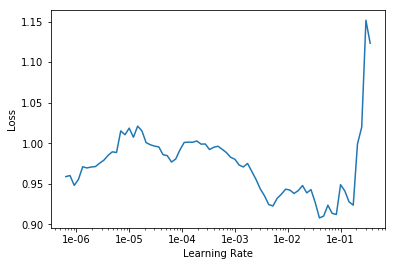

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr=1e-2
learn.metrics = [accuracy]

epoch,train_loss,valid_loss,accuracy,time
0,0.495728,0.464089,0.834235,00:37
1,0.519117,0.470871,0.824397,00:36
2,0.433802,0.399521,0.830792,00:36
3,0.415851,0.383808,0.839646,00:37
4,0.377384,0.399370,0.840630,00:36
5,0.362179,0.452077,0.835219,00:37
6,0.344157,1.391886,0.851943,00:37
7,0.354510,0.374553,0.848008,00:37
8,0.316212,0.508027,0.863256,00:36
9,0.310024,0.327718,0.871126,00:37


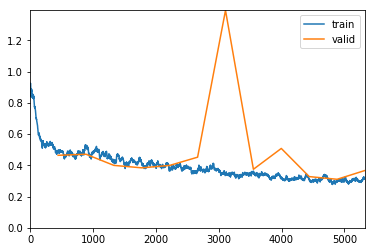

In [18]:
learn.fit_one_cycle(12,slice(lr))

In [19]:
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.340857,0.431259,0.851451,00:37
1,0.286368,0.320652,0.876537,00:37
2,0.301127,0.327989,0.875062,00:37
3,0.308177,0.276939,0.885391,00:37
4,0.292358,0.266580,0.888834,00:37
5,0.319709,0.272857,0.880964,00:36


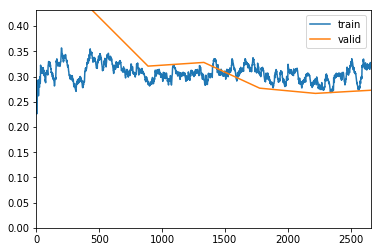

In [20]:
learn.fit(6)

In [21]:
learn.save('stage-2')

# Unfreeze

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


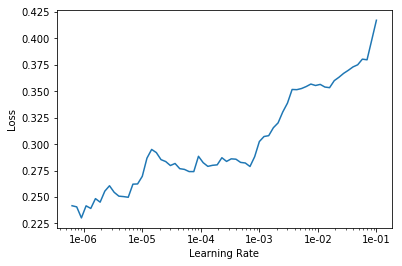

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.323097,0.495331,0.821938,00:37
1,0.323570,0.281607,0.877029,00:37
2,0.301876,0.296575,0.872602,00:37
3,0.257731,0.263193,0.871126,00:37
4,0.245505,0.436022,0.890310,00:39
5,0.236088,0.535939,0.920315,00:37
6,0.245879,0.205092,0.913428,00:37
7,0.252101,9.463515,0.900639,00:37
8,0.228889,0.880203,0.923266,00:37
9,0.230528,19.272165,0.903099,00:37


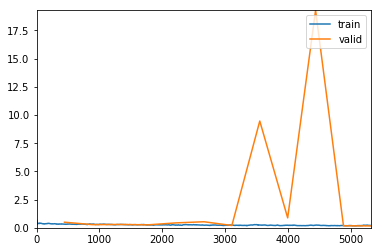

In [23]:
learn.fit(12)

In [24]:
learn.save('stage-3')

# Refreeze

In [25]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.171622,0.175440,0.929169,00:36
1,0.163975,0.170102,0.929661,00:36
2,0.148210,0.156010,0.944417,00:36
3,0.147509,0.276119,0.929169,00:35
4,0.157835,0.148283,0.947368,00:35
5,0.123391,0.150289,0.945401,00:36
6,0.135752,0.145259,0.945401,00:35
7,0.140573,0.153257,0.939498,00:36
8,0.135190,0.153444,0.938515,00:36


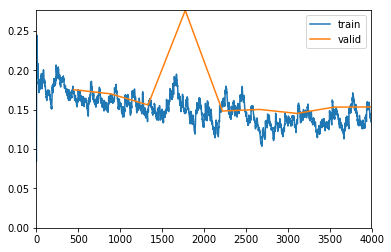

In [26]:
learn.fit_one_cycle(9)

In [27]:
learn.save('stage-4')

In [28]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

92.72011518478394


# Round 2

In [29]:
data_path = './data/'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,size=96,ds_tfms=tfms,bs=16,test='test')
       .normalize())

In [30]:
learn.data = data

In [31]:
learn.save('stage-5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


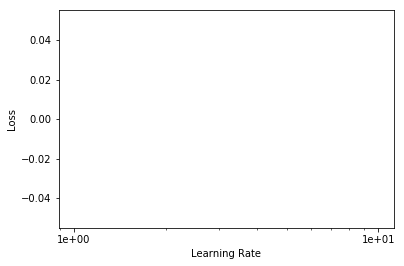

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy,time
0,0.296199,0.425005,0.878505,00:39
1,0.301016,12.574202,0.839154,00:38
2,0.306057,28.044163,0.887359,00:39
3,0.294805,20.235628,0.878505,00:39
4,0.263890,0.232700,0.916872,00:39
5,0.231186,7.555989,0.895229,00:40
6,0.197599,0.155142,0.933596,00:40
7,0.180233,0.144832,0.940974,00:39
8,0.167199,0.146325,0.940482,00:39


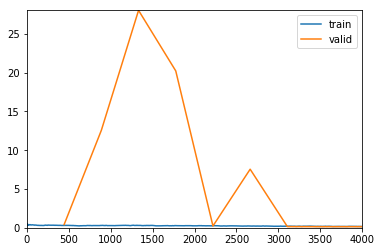

In [34]:
learn.fit_one_cycle(9,lr)

In [35]:
learn.save('stage-6')

# Unfreeze

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


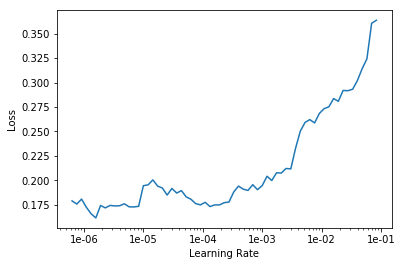

In [37]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.176098,0.185877,0.926709,00:39
1,0.234969,0.265834,0.885391,00:39
2,0.210600,1.425198,0.925726,00:39
3,0.207033,0.232934,0.892769,00:39
4,0.171946,0.142187,0.947860,00:39
5,0.146079,0.119489,0.952287,00:40
6,0.116742,0.098739,0.963109,00:39
7,0.085923,0.089404,0.965076,00:39
8,0.083424,0.086135,0.968028,00:39


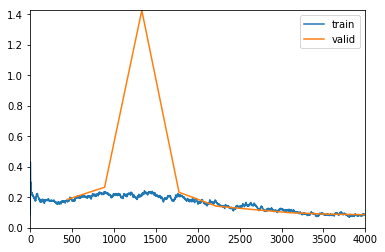

In [38]:
learn.fit_one_cycle(9)


# Refreeze

In [39]:
learn.freeze()

In [40]:
learn.save('stage-7')

epoch,train_loss,valid_loss,accuracy,time
0,0.075430,0.086072,0.968519,00:42
1,0.092537,0.091516,0.964584,00:43
2,0.084424,0.128679,0.964092,00:43
3,0.075290,1.260173,0.944909,00:42
4,0.068163,3.964224,0.933104,00:42
5,0.082417,0.087711,0.964584,00:42
6,0.077244,18.897089,0.944417,00:42
7,0.069220,0.475667,0.958682,00:42
8,0.085584,0.079337,0.971471,00:42


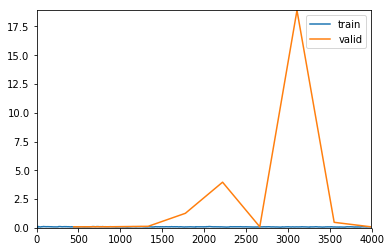

In [48]:
learn.fit(9)

In [50]:
learn.save('stage-8')

In [51]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

97.0978856086731


In [43]:
learn.load('stage-7')

Learner(data=ImageDataBunch;

Train: LabelList (7110 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Valid: LabelList (2033 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Test: LabelList (1014 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

epoch,train_loss,valid_loss,accuracy,time
0,0.071605,0.085167,0.968519,00:42
1,0.094484,0.086372,0.967536,00:42
2,0.083594,0.090081,0.965568,00:43
3,0.084620,0.082231,0.970487,00:42
4,0.078484,0.079613,0.971471,00:42
5,0.074136,0.100882,0.964092,00:43
6,0.077516,0.089787,0.969011,00:42
7,0.060592,0.080796,0.967536,00:43
8,0.076087,0.079431,0.968519,00:42


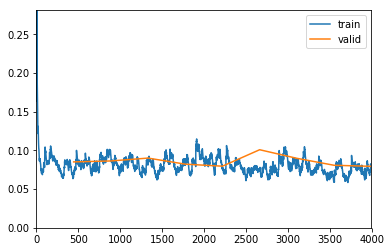

In [44]:
learn.fit_one_cycle(9)

In [45]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

96.80275321006775


In [46]:
learn.save('stage-9')

In [52]:
learn.load('stage-7')

Learner(data=ImageDataBunch;

Train: LabelList (7110 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Valid: LabelList (2033 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Test: LabelList (1014 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


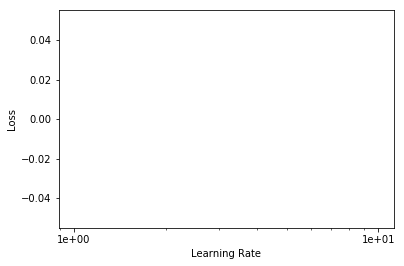

In [53]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.076303,0.087626,0.964092,00:42
1,0.074803,0.085592,0.969503,00:42
2,0.074568,0.085253,0.969503,00:42
3,0.068591,0.085794,0.967536,00:42
4,0.066993,0.084040,0.968519,00:42
5,0.061766,0.086496,0.966060,00:42
6,0.077494,0.085632,0.968028,00:41
7,0.068807,0.085059,0.968519,00:42
8,0.090913,0.084619,0.969011,00:42


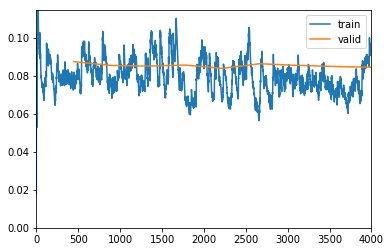

In [54]:
learn.fit_one_cycle(9,slice(1e-6,1e-4))

In [55]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

97.24544882774353


In [56]:
learn.save('stage-10')

In [57]:
learn.load('stage-7')

Learner(data=ImageDataBunch;

Train: LabelList (7110 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Valid: LabelList (2033 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Test: LabelList (1014 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

epoch,train_loss,valid_loss,accuracy,time
0,0.088726,0.083796,0.969995,00:41
1,0.081924,0.086371,0.965076,00:41
2,0.071693,0.082787,0.971471,00:41
3,0.075479,0.082376,0.970487,00:40
4,0.095278,0.083967,0.967536,00:42
5,0.072874,0.082170,0.970979,00:42
6,0.067315,0.081178,0.972946,00:42
7,0.068224,0.082147,0.968519,00:42
8,0.088618,0.079920,0.970979,00:42


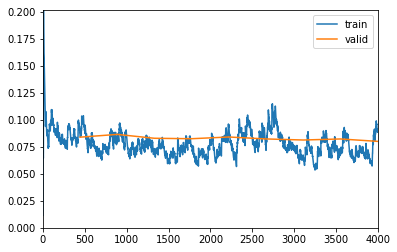

In [58]:
learn.fit(9,1e-4)

In [59]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

97.14707136154175


In [60]:
learn.save('stage-11')

In [61]:
learn.load('stage-10')

Learner(data=ImageDataBunch;

Train: LabelList (7110 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Valid: LabelList (2033 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
tesla,tesla,tesla,tesla,tesla
Path: data;

Test: LabelList (1014 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

# Round 3

In [62]:
data_path = './data/'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,size=224,ds_tfms=tfms,bs=16,test='test')
       .normalize())

In [63]:
learn.data = data

In [64]:
learn.save('stage-12')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


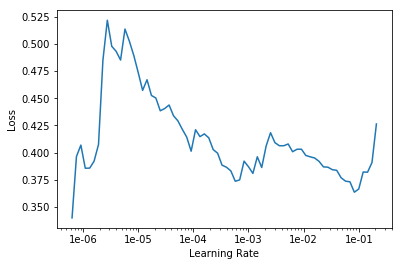

In [69]:
learn.lr_find()
learn.recorder.plot()

In [70]:
lr = 5e-4

epoch,train_loss,valid_loss,accuracy,time
0,0.426196,0.384089,0.868667,01:12
1,0.334348,0.286364,0.877521,01:11
2,0.304133,0.746152,0.878505,01:12
3,0.295806,0.278742,0.888834,01:12
4,0.301167,1.593374,0.891294,01:12
5,0.282535,0.228590,0.898180,01:12
6,0.267267,0.221471,0.903591,01:12
7,0.266761,0.222254,0.901623,01:12
8,0.293843,0.247754,0.902115,01:11


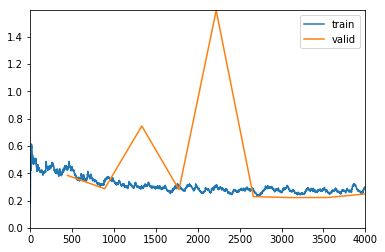

In [71]:
learn.fit_one_cycle(9,slice(lr))

In [72]:
learn.save('stage-13')

# Unfreeze

In [76]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


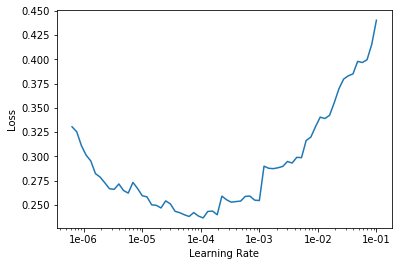

In [79]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.254674,0.235420,0.909493,01:11
1,0.246844,0.199665,0.934579,01:11
2,0.187428,0.170463,0.944909,01:10
3,0.182518,0.165251,0.948352,01:11
4,0.203537,0.141057,0.956714,01:13
5,0.171290,0.139863,0.959666,01:11
6,0.174232,0.107689,0.958682,01:12
7,0.133732,0.105629,0.958190,01:10
8,0.151000,0.093846,0.966060,01:12


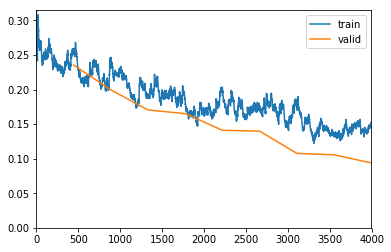

In [80]:
learn.fit(9,slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.142284,0.103894,0.956714,01:12
1,0.141698,0.089553,0.967536,01:11
2,0.131108,0.091044,0.966552,01:12
3,0.144123,0.088847,0.967536,01:13
4,0.128006,0.085827,0.969503,01:11
5,0.113621,0.081282,0.968028,01:13


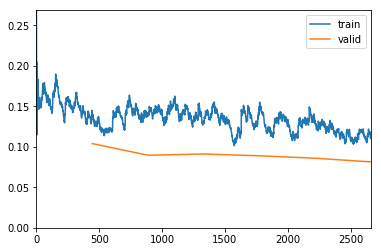

In [81]:
learn.fit(6,slice(1e-4))

In [84]:
learn.save('stage-14')

# Refreeze

In [92]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


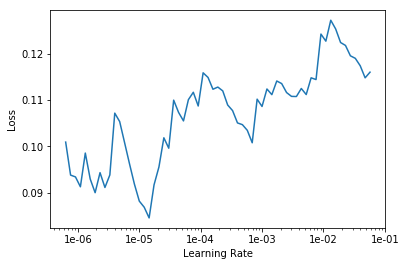

In [93]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.116822,0.088193,0.968028,01:11
1,0.133356,0.080369,0.970487,01:11
2,0.117246,0.079741,0.969011,01:10
3,0.126930,0.080115,0.967044,01:11
4,0.109253,0.081228,0.968028,01:09
5,0.123951,0.274263,0.967044,01:11
6,0.114779,0.079101,0.970487,01:10
7,0.112380,0.080678,0.969011,01:10
8,0.118033,0.082609,0.969011,01:10


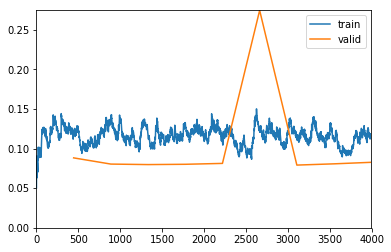

In [94]:
learn.fit(9,slice(1e-4))

In [95]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

96.60599827766418


In [96]:
notebook_save()
time.sleep(3) # to save the checkpoint
nb_name = model_save_dir+'_acc_'+str(tta)[:4]+'.html'
os.system(f"jupyter nbconvert {get_notebook_name()} --output {nb_name}")
nb_name

This notebook has been saved


'train_log/resnet18-fastai/004.26-03-2019-05-05_acc_96.6.html'